In [11]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_moons, load_iris, load_diabetes

import matplotlib.pyplot as plt

import joblib
import torch
import pickle
import warnings

In [12]:
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

with open("Amazon_products.pkl", 'rb') as f:
    dt = pickle.load(f)

In [13]:
dt

,asin,title,price,list_price,rating,reviews,sold_past_month,is_bestseller,is_prime,is_amazon_choice,has_sustainability_features,available_offers,amazon_choice_type,brand,free_delivery_date,fastest_delivery_date
0,B0DJK7NW1J,"15.6 Inch Laptops, Windows 11 Laptop Computers...",199.98,679.99,4.4 out of 5 stars,48,100+,False,False,False,False,NaN,NaN,NaN,NaN,NaN
1,B0BS4BP8FB,Acer Aspire 3 A315-24P-R7VH Slim Laptop | 15.6...,279.99,321.99,4.4 out of 5 stars,"39,243",8K+,False,False,True,False,6,Overall Pick,NaN,NaN,NaN
2,B0DKDY78K3,"Newest Gaming Laptop, Laptop with AMD Ryzen 7 ...",649.99,"1,699.99",4.8 out of 5 stars,18,100+,False,False,False,False,NaN,NaN,NaN,NaN,NaN
3,B0CPL25J3W,"HP Portable Laptop, Student and Business, 14"" ...",197.35,269.00,4.1 out of 5 stars,"1,678",1K+,False,False,False,False,25,NaN,NaN,NaN,NaN
4,B0947BJ67M,"HP 14 Laptop, Intel Celeron N4020, 4 GB RAM, 6...",176.00,209.99,4.0 out of 5 stars,"1,861",4K+,False,False,False,False,50,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,B0B5GRGCX5,"Lenovo L15 Portable Monitor, 15.6” Display, Fu...",162.00,180.44,4.3 out of 5 stars,46,500+,False,False,False,False,28,NaN,NaN,NaN,NaN
1238,B0CH9XW8RK,ARZOPA Portable Monitor 15.6'' FHD 1080P - Ult...,85.99,NaN,4.4 out of 5 stars,"1,092",3K+,False,True,False,False,4,NaN,NaN,"Tue, Nov 19",NaN
1239,B0CY896H5G,"Laptop Screen Extender 14"" 1080P FHD IPS, Port...",299.99,NaN,4.4 out of 5 stars,422,1K+,False,True,False,False,3,NaN,NaN,"Tue, Nov 19",NaN
1240,B0C77WJ6F5,Yodoit Portable Monitor for Laptop 1920×1080 1...,49.99,69.99,4.0 out of 5 stars,416,1K+,False,True,False,False,NaN,NaN,NaN,"Tue, Nov 19",NaN


In [14]:
all_dt = dt[["price", "list_price", "rating", "sold_past_month", "reviews", "is_bestseller", "is_prime", "is_amazon_choice", "available_offers"]]

In [15]:
def str_to_float(s):
    if isinstance(s, str):
        s = float("".join(s.split(',')))
    return s

def stars_to_rating(s):
    if isinstance(s, str):
        r = float(s.split()[0])
        return r
    return s


def to_bool(s):
  return int(s)

def spm(s):
    if isinstance(s, str):
        if s[-2] == "K":
            return int(s[:-2]) * 1000
        return int(s[:-1])
    return s

In [16]:
all_dt.dropna(inplace=True, subset=['rating'])

In [17]:
def upd_dt(X):
    X["price"] = X["price"].apply(str_to_float)
    X["list_price"] = X["list_price"].apply(str_to_float)
    X["rating"] = X['rating'].apply(stars_to_rating)
    X['sold_past_month'] = X['sold_past_month'].apply(spm)
    X['reviews'] = X['reviews'].apply(str_to_float)
    X["available_offers"] = X["available_offers"].apply(str_to_float)
    X['is_bestseller'] = X['is_bestseller'].apply(to_bool)
    X['is_prime'] = X['is_prime'].apply(to_bool)
    X['is_amazon_choice'] = X['is_amazon_choice'].apply(to_bool)
    return X

all_dt = upd_dt(all_dt)

In [18]:
def fill_na(x, col_n):
  mean_val = x[col_n].mean()
  if col_n == 'available_offers':
    mean_val = 0
  x[col_n].fillna(mean_val, inplace=True)


for n in all_dt:
    fill_na(all_dt, n)

In [19]:
all_dt['list_price'] = all_dt[['list_price', 'price']].apply(lambda x: x['list_price'] if x['list_price'] > x['price'] else x['price'], axis=1)
all_dt['diff_price'] = all_dt['list_price'] - all_dt['price']
all_dt['log_price'] = np.log2(all_dt['price'] )

# mtm = more_than_mean
all_dt['reviews_mtm'] = all_dt['reviews'].apply(lambda x: int(x > all_dt['reviews'].mean()))
# all_dt['price_mtm'] = all_dt['price'].apply(lambda x: int(x > all_dt['price'].mean()))
all_dt['spm_mtm'] = all_dt['sold_past_month'].apply(lambda x: int(x > all_dt['sold_past_month'].mean()))
all_dt['avaliable_offers_mtm'] = all_dt['available_offers'].apply(lambda x: int(x > all_dt['available_offers'].mean()))
# all_dt['is_bestseller_and_prime'] = all_dt['is_bestseller'] * all_dt['is_prime']

all_dt

,price,list_price,rating,sold_past_month,reviews,is_bestseller,is_prime,is_amazon_choice,available_offers,diff_price,log_price,reviews_mtm,spm_mtm,avaliable_offers_mtm
0,199.98,679.990000,4.4,100.0,48.0,0,0,0,0.0,480.010000,7.643712,0,0,0
1,279.99,321.990000,4.4,8000.0,39243.0,0,0,1,6.0,42.000000,8.129231,1,1,1
2,649.99,1699.990000,4.8,100.0,18.0,0,0,0,0.0,1050.000000,9.344274,0,0,0
3,197.35,269.000000,4.1,1000.0,1678.0,0,0,0,25.0,71.650000,7.624613,0,0,1
4,176.00,209.990000,4.0,4000.0,1861.0,0,0,0,50.0,33.990000,7.459432,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,162.00,180.440000,4.3,500.0,46.0,0,0,0,28.0,18.440000,7.339850,0,0,1
1238,85.99,207.356346,4.4,3000.0,1092.0,0,1,0,4.0,121.366346,6.426097,0,1,0
1239,299.99,299.990000,4.4,1000.0,422.0,0,1,0,3.0,0.000000,8.228771,0,0,0
1240,49.99,69.990000,4.0,1000.0,416.0,0,1,0,0.0,20.000000,5.643568,0,0,0


In [20]:
X = torch.Tensor(all_dt[["price", "list_price", "sold_past_month", "reviews", "is_bestseller", "is_prime", "is_amazon_choice", "available_offers"]].to_numpy())
y = torch.Tensor(all_dt["rating"].to_numpy())

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [50]:
class OurNonLinearNet(torch.nn.Module):
    loss_fun = torch.nn.MSELoss(reduction="sum")
    def __init__(self, input_features, out_features, hidden_units):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_units)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_units, out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0009)


    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


    def fit(self, X, y, n_epochs=1000, print_loss=True):
        for epoch in range(n_epochs+1):

            self.train()
            y_logits = self(X).squeeze()
            loss = self.loss_fun(y_logits, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if print_loss and (epoch % 20 == 0):
                print(f"Epoch {epoch}: loss = {loss:.5f}")

    def predict(self, x):
        return self.forward(x)


    def predict_from_logit(self, x_logit):
        return torch.round(torch.sigmoid(x_logit))

In [51]:
net = OurNonLinearNet(8, 1, 800)

In [52]:
net.fit(X_train, y_train, n_epochs=15_000)

Epoch 0: loss = 261474448.00000
Epoch 20: loss = 977001024.00000
Epoch 40: loss = 151100976.00000
Epoch 60: loss = 25587760.00000
Epoch 80: loss = 1838550.37500
Epoch 100: loss = 128454.18750
Epoch 120: loss = 53788.41406
Epoch 140: loss = 25177.76562
Epoch 160: loss = 17550.26953
Epoch 180: loss = 15956.20312
Epoch 200: loss = 14818.08008
Epoch 220: loss = 13867.70703
Epoch 240: loss = 12964.05762
Epoch 260: loss = 12850.17383
Epoch 280: loss = 11631.86035
Epoch 300: loss = 10653.40625
Epoch 320: loss = 9673.88281
Epoch 340: loss = 9074.06641
Epoch 360: loss = 8660.11523
Epoch 380: loss = 8989.13867
Epoch 400: loss = 7324.47314
Epoch 420: loss = 6083.94385
Epoch 440: loss = 5291.90674
Epoch 460: loss = 4860.66846
Epoch 480: loss = 10889.58789
Epoch 500: loss = 7001.33887
Epoch 520: loss = 5935.91309
Epoch 540: loss = 5180.17578
Epoch 560: loss = 4626.40234
Epoch 580: loss = 4413.91699
Epoch 600: loss = 4263.90576
Epoch 620: loss = 4140.50586
Epoch 640: loss = 4075.67627
Epoch 660: los

tensor(0.2229, grad_fn=<MseLossBackward0>)


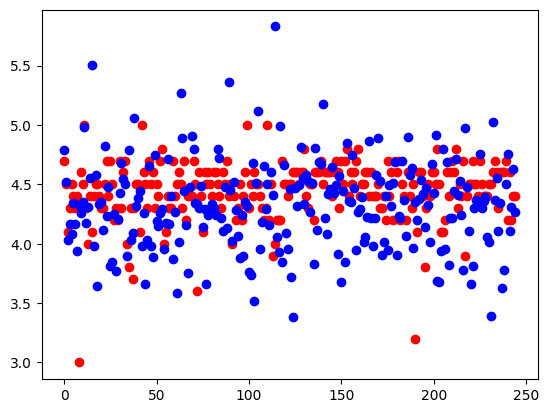

In [53]:
print(torch.nn.MSELoss()(y_test, net(X_test).squeeze()))


plt.scatter(range(len(y_test)), y_test.detach().numpy(), c="r")
plt.scatter(range(len(y_test)), net(X_test).squeeze().detach().numpy(), c="b")
plt.show()

In [40]:
net(X_test).squeeze()

tensor([0.3027, 5.6888, 2.6816, 5.6876, 4.7980, 3.4853, 3.1599, 1.7630, 3.8371,
        5.2256, 4.9186, 4.0290, 3.1347, 5.8939, 4.9789, 8.0907, 4.3640, 4.8937,
        0.7895, 1.2889, 4.2287, 4.0756, 5.3289, 2.1308, 3.4945, 0.3707, 4.8987,
        3.8655, 3.2187, 4.1560, 4.1832, 4.4854, 4.4147, 4.7127, 1.8310, 3.5901,
        3.2087, 3.5014, 1.2410, 4.3867, 3.0888, 1.7914, 5.8049, 3.6291, 5.6407,
        2.3401, 5.0451, 1.7638, 1.2285, 0.8857, 4.0734, 3.1401, 3.8716, 4.8893,
        4.7752, 3.0424, 2.6736, 5.6876, 1.8867, 1.9175, 5.4969, 5.7523, 0.7922,
        0.8250, 1.4212, 4.0735, 5.5771, 5.0602, 4.4706, 0.3063, 6.0234, 2.9975,
        2.6730, 3.4489, 5.4645, 1.7918, 5.0824, 5.6407, 2.9866, 3.3241, 4.9887,
        4.5175, 1.7991, 5.1497, 1.3390, 5.1870, 4.5604, 4.5733, 2.0501, 3.2369,
        4.9877, 2.6013, 2.9386, 3.7802, 3.9327, 3.7448, 4.6101, 2.5916, 2.5647,
        3.3082, 1.7266, 2.1630, 5.8091, 1.9435, 4.2577, 4.4372, 2.1492, 2.4748,
        2.4330, 3.0074, 4.4962, 3.1184, 